```

```

DOnwload dataset

https://github.com/nlp-with-transformers/notebooks/blob/main/07_question-answering.ipynb

In [1]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

download electronics subfield

In [2]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Found cached dataset subjqa (/home/cian/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
print(subjqa["train"]["answers"][3])

{'text': ['the best of all of them'], 'answer_start': [1609], 'answer_subj_level': [1], 'ans_subj_score': [0.30000001192092896], 'is_ans_subjective': [False]}


answers stored in `text` field and starting aswer indices `answer_start`, use `flatten()` to make it clearer fir us

In [4]:

import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


focus on important cols

In [5]:
qa_cols = ["title", "question", "answers.text", 
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(5, random_state=7)
sample_df
     

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...
961,B0074BW614,How is the cell phone screen?,[The interface takes a few tries to get used t...,[535],"Don't get me wrong, I love my e-ink kindle to ..."
1188,B00BGGDVOO,Do you have any computer with mouse?,[],[],After deciding to ditch cable TV I started to ...
999,B007P4VOWC,How is the camera?,[],[],I purchased the Tab 2 for my fianc&eacute; and...


empty`answers.text` are unanswerable

In [6]:


start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]
     

'this keyboard is compact'

In [7]:
import matplotlib.pyplot as plt


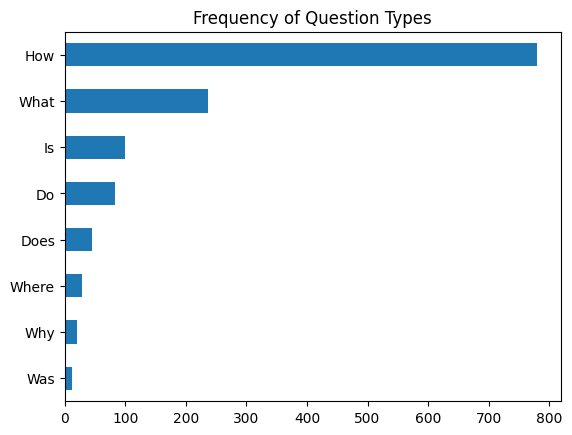

In [8]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

Tokenise text for QA

To encode our text will load MiniLM model chkpoint (selectong our pretrained model)

In [9]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

test

In [10]:

question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [11]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df
     

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [12]:

print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


skip.......

# haystack and elasticbeam



**using `launch_es`**


`docker run -d -p 9200:9200 -e "discovery.type=single-node" elasticsearch:8.6.1`



In [13]:
# Suppress Haystack logging
import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
              "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base", 
              "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

In [14]:
%env TOKENIZERS_PARALLELISM=false
     

env: TOKENIZERS_PARALLELISM=false


In [15]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz


gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [16]:
!ls

 elasticsearch-7.9.2			   pytroch_feck_about.ipynb
 elasticsearch-7.9.2-linux-x86_64.tar.gz  'QA Test_2.ipynb'
 elasticsearch-8.6.1			  'QA Test_3.ipynb'
 electronics-test.json			  'QA Test.ipynb'
 electronics-train.json			   test2022
 electronics-validation.json		   TF_1.ipynb


Need to sintall 

## Install Docker Desktop on Ubuntu

https://docs.docker.com/desktop/install/ubuntu/

I have teh DEB `docker-desktop-4.16.2-amd64.deb`


1. Set up Docker’s package repository.

1. Download latest DEB package.

1. Install the package with apt as follows:

```
sudo apt-get install ./docker-desktop-<version>-<arch>.deb
    
sudo apt-get install ./docker-desktop-4.16.2-amd64deb


```

### Launch Docker Desktop🔗

```
systemctl --user start docker-desktop
```
above cause error, but `systemctl start docker` works after inputting sudo pswd

When Docker Desktop starts, it creates a dedicated context that the Docker CLI can use as a target and sets it as the current context in use. This is to avoid a clash with a local Docker Engine that may be running on the Linux host and using the default context. On shutdown, Docker Desktop resets the current context to the previous one.

The Docker Desktop installer updates Docker Compose and the Docker CLI binaries on the host. It installs Docker Compose V2 and gives users the choice to link it as docker-compose from the Settings panel. Docker Desktop installs the new Docker CLI binary that includes cloud-integration capabilities in /usr/local/bin and creates a symlink to the classic Docker CLI at /usr/local/bin/com.docker.cli.

After you’ve successfully installed Docker Desktop, you can check the versions of these binaries by running the following commands:


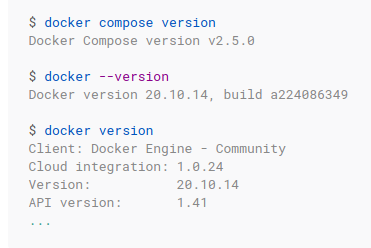

## install haystack:

`pip install farm-haystack[all]`

In [17]:
# Alternative if Docker is installed, which it is
from haystack.utils import launch_es
     

/home/cian/anaconda3/envs/qa/lib/python3.10/site-packages/espnet2/gan_tts/vits/vits.py:43: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) >= LooseVersion("1.6.0"):
/home/cian/anaconda3/envs/qa/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)



Its best to restart kernel and run again (the importing [all] worked

some warnins now

In [18]:
launch_es()

Unable to find image 'elasticsearch:7.17.6' locally
7.17.6: Pulling from library/elasticsearch

code: https://github.com/nlp-with-transformers/notebooks/blob/main/07_question_answering_v2.ipynb

### test haystack

In [19]:

!curl -X GET "localhost:9200/?pretty"

{
  "name" : "19f8f6ef2078",
  "cluster_name" : "docker-cluster",
  "cluster_uuid" : "zAX32hbFSh-8rLdfND_c-w",
  "version" : {
    "number" : "7.17.6",
    "build_flavor" : "default",
    "build_type" : "docker",
    "build_hash" : "f65e9d338dc1d07b642e14a27f338990148ee5b6",
    "build_date" : "2022-08-23T11:08:48.893373482Z",
    "build_snapshot" : false,
    "lucene_version" : "8.11.1",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


## Now that elastic search server is running, we instantiate document store

In [20]:
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever 
document_store = ElasticsearchDocumentStore(return_embedding=True)
     

/home/cian/anaconda3/envs/qa/lib/python3.10/site-packages/elasticsearch/connection/base.py:190: ElasticsearchDeprecationWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)
/home/cian/anaconda3/envs/qa/lib/python3.10/site-packages/elasticsearch/connection/http_urllib3.py:275: DeprecationWarning: HTTPResponse.getheaders() is deprecated and will be removed in urllib3 v2.1.0. Instead access HTTPResponse.headers directly.
  return response.status, response.getheaders(), raw_data


## It's a good idea to flush Elasticsearch with each notebook restart

In [21]:
# It's a good idea to flush Elasticsearch with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents(index="document")
    document_store.delete_documents(index="label")

Since version 1.0 of Haystack, Documents now have a field content, which replaces the field text. This change was introduced because Documents have become more flexible and can also store tables in addition to texts.

### `ElasticsearchDocumentStore` creates two indices by default, document and label.


For now, populate document indx with SubjQA reviews, and `meta`

# **we skipped the long passages handling, do it next time** `return_overflowing_tokens=True`

In [22]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"content": row["context"], "id": row["review_id"],
             "meta":{"item_id": row["title"], "question_id": row["id"], 
                     "split": split}} 
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(documents=docs, index="document")
    
print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


## Initializing a retriever

In Haystack 1.4 ElasticsearchRetriever was renamed to BM25Retriever. You can still use ElasticsearchRetriever for compatibility reasons in version 1.5 but it might be removed in future releases.

In [23]:
from haystack.nodes.retriever import BM25Retriever

bm25_retriever = BM25Retriever(document_store=document_store)

In [24]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = bm25_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})
     

In [25]:
print(retrieved_docs[0])
     

<Document: id=4a6aa9c7808ebba8d35aeecbcc3c30fe, content='This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never ...'>


## Initializing a reader

In [26]:
from haystack.nodes import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2" #alternative larger models: deepset/roberta-base-squad2-distilled or deepset/xlm-roberta-large-squad2 or the tiny distilled model: deepset/tinyroberta-squad2
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride, 
                    return_no_answer=True)

In [27]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))


{'query': 'How much music can this hold?', 'no_ans_gap': 12.64808464050293, 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5293049216270447, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}], 'offsets_in_context': [{'start': 38, 'end': 48}], 'document_id': 'e344757014e804eff50faa3ecf1c9c75', 'meta': {}}>]}


# All into a Pipeline

In [28]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)

The format of parameters that can be passed to a pipeline has slightly changed. In the old version, the method call was
```
preds = pipe.run(query=query, top_k_retriever=3, top_k_reader=n_answers,
                 filters={"item_id": [item_id], "split":["train"]})
```
Now, you can specify the name of the node, e.g., "Retriever", that you want to pass parameters to.

In [29]:
n_answers = 3
preds = pipe.run(query=query, params={"Retriever": {"top_k": 3, "filters":{"item_id": [item_id], "split":["train"]}}, 
                                      "Reader": {"top_k": n_answers}})

print(f"Question: {preds['query']} \n")

for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}...")
    print("\n\n")
     

Question: Is it good for reading? 

Answer 1: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...



Answer 2: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la...



Answer 3: 
Review snippet: ...None...





# Evaluation and improvement

In [30]:

from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=bm25_retriever)

In [31]:

from haystack import Label, Answer, Document

labels = []
for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False, filters={"item_id": [meta["item_id"]], "split":["test"]})
            labels.append(label)
    # Populate labels for questions without answers
    else:
        label = Label(
            query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True, filters={"item_id": [row["title"]], "split":["test"]})  
        labels.append(label)
     

In [32]:

document_store.write_labels(labels, index="label")

print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 455 question-answer pairs


In [33]:

labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

330


may want to ignore urrlib warnings

In [34]:

# We can run the pipeline with the desired top_k value like this
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()

/home/cian/anaconda3/envs/qa/lib/python3.10/site-packages/elasticsearch/connection/base.py:190: ElasticsearchDeprecationWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)
/home/cian/anaconda3/envs/qa/lib/python3.10/site-packages/elasticsearch/connection/http_urllib3.py:275: DeprecationWarning: HTTPResponse.getheaders() is deprecated and will be removed in urllib3 v2.1.0. Instead access HTTPResponse.headers directly.
  return response.status, response.getheaders(), raw_data
/home/cian/anaconda3/envs/qa/lib/python3.10/site-packages/elasticsearch/connection/base.py:190: ElasticsearchDeprecationWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See

In [35]:
print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}")


Recall@3: 0.96


You can check the predictions of any query by inspecting the dataframe:



In [36]:
eval_df = eval_result["Retriever"]
eval_df[eval_df["query"] == "How do you like the lens?"][["query", "filters", "rank", "content", "gold_document_contents", "document_id"]]

KeyError: "['content', 'gold_document_contents'] not in index"

skip......

# Domain Adaptation

fine-tune MiniLM on SubjQA training set


1. re-structure into squad format
1. fine-tune reader and compare to baseline

In [37]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # Add question-answer pairs to qas
            qas.append({"question": question, "id": qid, 
                        "is_impossible": is_impossible, "answers": answers})
        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

In [38]:

product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

In [39]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # Create `paragraphs` for each product ID
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # Save the result to disk
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)
            
convert_to_squad(dfs)

In [50]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=5,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]

Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
ERROR:haystack.modeling.data_handler.processor:Unable to convert 5 samples to features. Their ids are : 60-0-0, 83-0-0, 471-0-0, 75-0-0, 143-0-0


Preprocessing dataset:   0%|          | 0/1 [00:00<?, ? Dicts/s]

ERROR:haystack.modeling.data_handler.processor:Unable to convert 5 samples to features. Their ids are : 75-0-0, 60-0-0, 83-0-0, 471-0-0, 143-0-0


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

with 1 full epoch I get what I dread:


```
RuntimeError: CUDA out of memory. Tried to allocate 108.00 MiB (GPU 0; 5.80 GiB total capacity; 4.51 GiB already allocated; 37.75 MiB free; 4.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
```

then reduce bs and run a secind time:


`RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 5.80 GiB total capacity; 4.52 GiB already allocated; 48.00 MiB free; 4.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF`


now running at 15:33 24/02, bs=5, epch=1

--------------------
Error displaying widget: model not found

With 0.1 epoch we get:

cant display module, I am guessing the status bar

and still this error

`ERROR:haystack.modeling.data_handler.processor:Unable to convert 5 samples to features.`


'..' means go up one level



/anaconda3/envs/qa/lib/python3.10/site-packages/haystack/nodes/reader/farm.py:357


~/anaconda3/envs/qa/lib/python3.10/site-packages/haystack/modeling/model/adaptive_model.py:258


`ls -a` show hidden gfiles



The model is stored at:

`/home/cian/.cache/huggingface/hub/models--deepset--minilm-uncased-squad2`

`farm.py:357, in FARMReader._training_procedure `

this is trying to create a dirk and doesnt have permission



chmod -R 777 Projects

# permission solution:

the farm.py scripts are trying to mkdir, but I need to be sudo

The script is trying to mkdir, so I do it manually (with sudO) in terminal, and then chmod it to be safe

chmod -R 777 ../../saved_models

next:

PermissionError: [Errno 13] Permission denied: '../../saved_models/Bert'





In [ ]:
!chmod 777 /anaconda3/envs/qa/lib/python3.10/site-packages/haystack/nodes/reader/farm.py

testing with a fraction of a epoch (0.01) we get this error

`
PermissionError: [Errno 13] Permission denied: '../../saved_models'`

`..` is the parent of dirk


https://github.com/deepset-ai/haystack/issues/2836

@tstadel can I take this up ? I wish to get a hand in. This just requires
```
save_dir = f"../../saved_models/{self.inferencer.model.language_model.name}"
```
to be changed to

```
save_dir = f"./saved_models/{self.inferencer.model.language_model.name}"
in farm.py
```

https://farm.deepset.ai/api/modeling.html

-------------

trying `chmod 777 ` ?


chmod 777 


------------------

### Path

`FARMReader.train()`

Do I need to specify the dirk? 

`data_dir="."`

currently `QA Test_2.ipynb` PATH IS `home/cian/Projects`


GETTIG ERROR `ERROR:haystack.modeling.data_handler.processor:Cannot download Projects. Unknown data source.
`

`FileNotFoundError: [Errno 2] No such file or directory: 'home/cian/Projects/electronics-train.json'
`



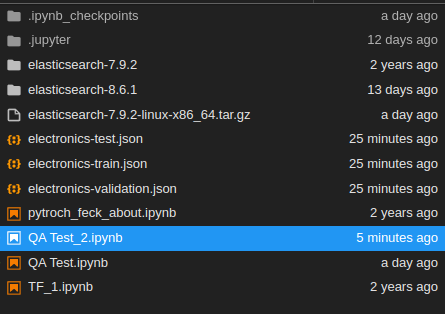
`
--------------

AFter rollback of torch/CUDA it appears to be running but has warnings 

feb 22 at 15:47

https://stackoverflow.com/questions/62359175/pytorch-says-that-cuda-is-not-available-on-ubuntu

```
/home/cian/anaconda3/envs/qa/lib/python3.10/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
```



-------------------

full stack:

```
Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing loss. If you really like to listen to the most of your music and you must wear earbuds then these are not for you.I also have to note that these are packaged in a difficult to open blister pack that required several passes with utility shears to break into. I hate to see all the plastic that has to be discarded just to get this product out of the package.Cosmetically, they are OK. They don't hurt my ears and are comfortable to me. They come with a couple of other size ear pieces if you are hard to fit. The wires take a set when folded so they are not very well-behaved and don't coil nicely and lie flat when you put them away. These will be a little bird's nest of tangled wires when you set them aside. ANSWERNOTFOUND' not contained in context.
Example will not be converted for training/evaluation.
Preprocessing dataset:  33%|███▎      | 1/3 [00:00<00:01,  1.86 Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer using start/end indices is '  Operation of the menus and contro' while gold label text is 'Operation of the menus and controls'.
Example will not be converted for training/evaluation.
WARNING:haystack.modeling.data_handler.processor:Answer using start/end indices is '  This camera performs like the pros.  Fast accurate and easy to operat' while gold label text is 'This camera performs like the pros.  Fast accurate and easy to operated'.
Example will not be converted for training/evaluation.
Preprocessing dataset:  67%|██████▋   | 2/3 [00:01<00:00,  1.74 Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'enjoy my music.  When I used my old one ear headset for music, the connection was not that good even if I put the phone in my pants pocket.  I used it on iPhone 4S and iPad 3 for music, phone calls, and audible app.  All Bluetooth controls work fine. ANSWERNOTFOUND' not contained in context.
Example will not be converted for training/evaluation.
WARNING:haystack.modeling.data_handler.processor:Answer 'is good.  First unit defective.  Directions are weak and limited, Net support just plain bad. Roku insists on registration, [I think SEVEN times for us] before asking dumb questions and forcing us to run from computer to TV and back.  This is a Roku 3, and apparently it's too new for them to handle. ANSWERNOTFOUND' not contained in context.
Example will not be converted for training/evaluation.
Preprocessing dataset: 100%|██████████| 3/3 [00:01<00:00,  1.96 Dicts/s]
ERROR:haystack.modeling.data_handler.processor:Unable to convert 5 samples to features. Their ids are : 83-0-0, 471-0-0, 143-0-0, 60-0-0, 75-0-0
Preprocessing dataset: 100%|██████████| 1/1 [00:00<00:00,  3.32 Dicts/s]
ERROR:haystack.modeling.data_handler.processor:Unable to convert 5 samples to features. Their ids are : 83-0-0, 471-0-0, 60-0-0, 143-0-0, 75-0-0
/home/cian/anaconda3/envs/qa/lib/python3.10/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
  ```

should of been done erlier, 

The evaluation of a reader can be done by creating a pipeline that consists only of a single node: a reader. In this case, the pipeline.eval() gets the relevant documents as direct input from the labels

In [51]:

from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
                
    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

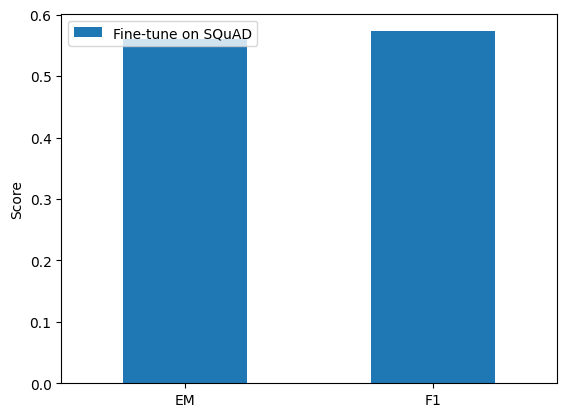

In [52]:

def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval).reindex(["exact_match", "f1"])
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

In [53]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)

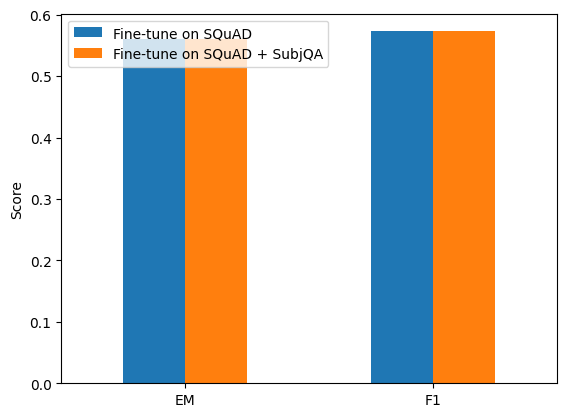

In [54]:

plot_reader_eval(reader_eval)

`RuntimeError: philox_cuda_state for an unexpected CUDA generator used during capture. In regions captured by CUDA graphs, you may only use the default CUDA RNG generator on the device that's current when capture begins. If you need a non-default (user-supplied) generator, or a generator on another device, please file an issue.`

https://github.com/huggingface/transformers/issues/21378


pt-1.13.0 and 1.13.1 are buggy wrt to disappearing error messages in cuda, this has been fixed in pytorch/pytorch#91758 - and the fix is already available in nightlies.

So if you run into situations like this Issue and the cuda error is incomprehensible - please use either torch<1.13 which doesn't have this problem or whatever the next version will be: pt-2.0.0 probably (or nightly if you're brave).


I am curr: `torch 1.13.1`

so downgrade (uninstall fully if any issues)


`pip install torch==1.4.0 `


https://pytorch.org/get-started/previous-versions/


new : `torch==1.12.1`

`torchvision 0.14.1 requires torch==1.13.1, but you have torch 1.12.1 which is incompatible.`


I did not input the entire list

```
# ROCM 5.1.1 (Linux only)
pip install torch==1.12.1+rocm5.1.1 torchvision==0.13.1+rocm5.1.1 torchaudio==0.12.1 --extra-index-url  https://download.pytorch.org/whl/rocm5.1.1
# CUDA 11.6
pip install torch==1.12.1+cu116 torchvision==0.13.1+cu116 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu116
# CUDA 11.3
pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
# CUDA 10.2
pip install torch==1.12.1+cu102 torchvision==0.13.1+cu102 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu102
# CPU only
pip install torch==1.12.1+cpu torchvision==0.13.1+cpu torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cpu
```


### check CUDA 

`nvidia-smi ` displays the COMPATIBLE CUDA ver for my hardware and NOT the actual curr , so my max comaptible version is `CUDA Version: 11.4`   `


- SHould U update? https://medium.com/@lyl1617670866/how-to-update-cuda-and-cudnn-on-ubuntu-18-04-4bfb762cf0b8#:~:text=To%20update%20cuda%20and%20cudnn%2C%20the%20first%20thing%20we%20should,Updates%2C%20and%20click%20Additional%20Drivers.

- 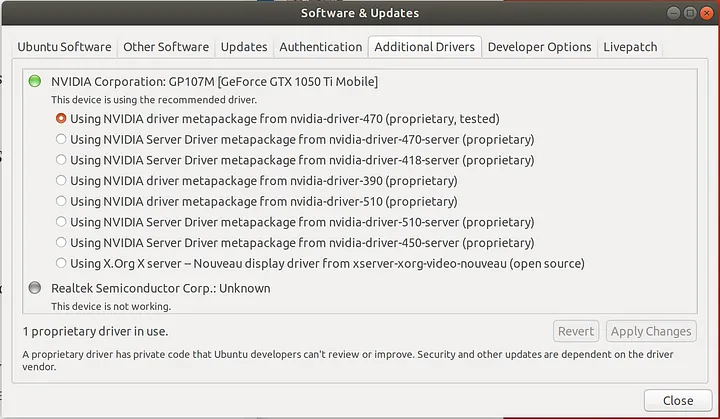


So I am running `pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113`
----------------------------------------

New issue:


`RuntimeError: false INTERNAL ASSERT FAILED at "../c10/cuda/CUDAGraphsC10Utils.h":73, please report a bug to PyTorch. Unknown CUDA graph CaptureStatus32614`
`

### checking CUDA

https://towardsdatascience.com/managing-cuda-dependencies-with-conda-89c5d817e7e1

```
(qa) cian@cian-G5-5500:~$ conda search cudatoolkit
Loading channels: done
# Name                       Version           Build  Channel             
cudatoolkit                      9.0      h13b8566_0  pkgs/main           
cudatoolkit                      9.2               0  pkgs/main           
cudatoolkit                 10.0.130               0  pkgs/main           
cudatoolkit                 10.1.168               0  pkgs/main           
cudatoolkit                 10.1.243      h6bb024c_0  pkgs/main           
cudatoolkit                  10.2.89      hfd86e86_0  pkgs/main           
cudatoolkit                  10.2.89      hfd86e86_1  pkgs/main           
cudatoolkit                 11.0.221      h6bb024c_0  pkgs/main           
cudatoolkit                   11.3.1      h2bc3f7f_2  pkgs/main  
```